#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv('taxi(1).csv')
df.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


***Изменим тип данных, проверим монотонны ли они и проведём ресемплирование по одному часу***

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
df = df.set_index('datetime')
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


In [6]:
df = df.resample('1H').sum()

df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод**

* Количество объектов сильно уменьшилось с 26496 до 4416
* Данные монотонны
* Данные отсортированы и ресемплированы

## Анализ

Изучим данные. Для этого посмотрим на тренды и сезонность исторических данных о заказах такси

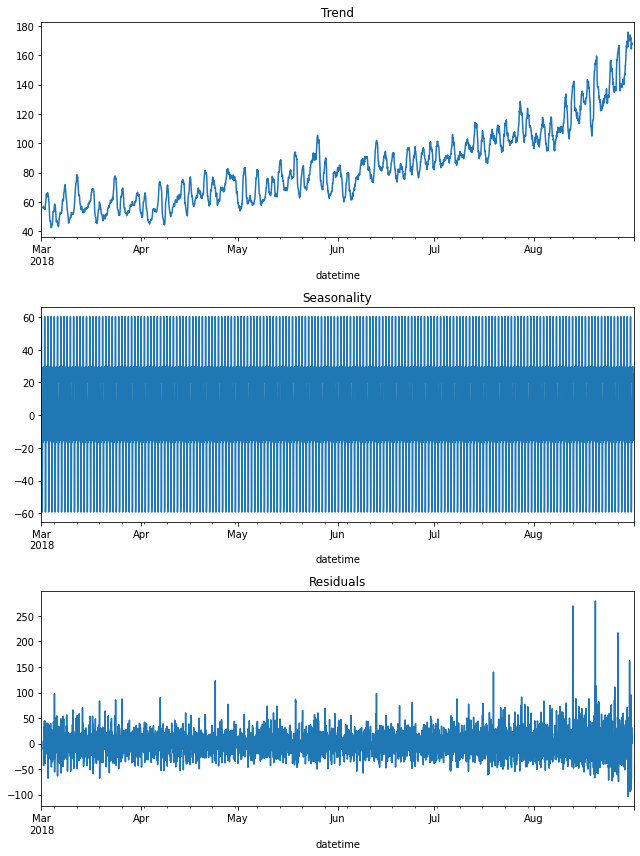

In [8]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(9, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Число заказов с марта по август постепенно растёт. Пики активности приходятся на летние месяцы отпусков.\
Сезонность за 6 месяцев мы определить не можем, поэтому посмотрим на неё в 1 неделю в августе

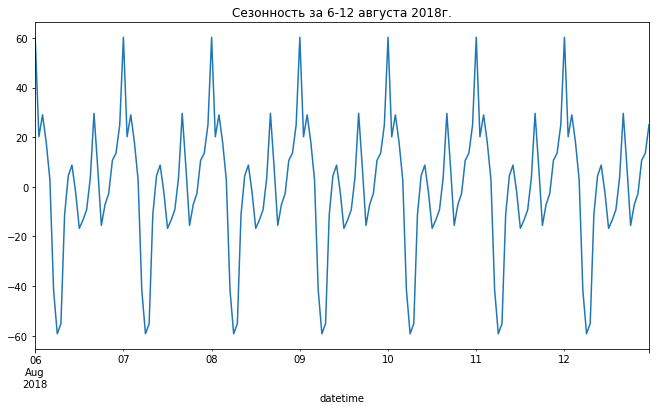

In [9]:
decomposed.seasonal['2018-08-06':'2018-08-12'].plot(figsize=(11, 6))
plt.title('Сезонность за 6-12 августа 2018г.');

На графике видно, что от дня недели сезонность не сильно зависит. Циклично повторяющаяся закономерность составляет 24 часа. Посмотрим 2 графика: первый и последний дни предоставленных данных

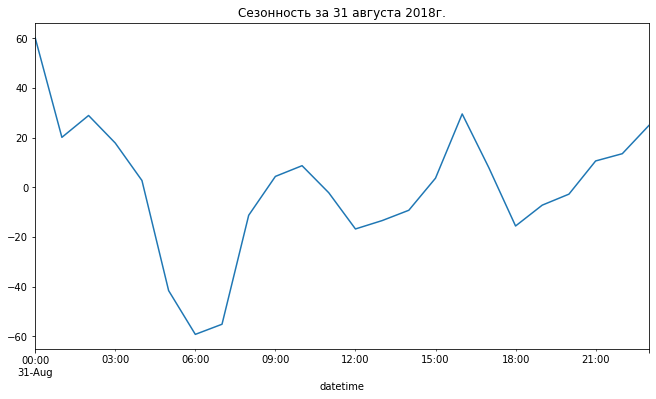

In [10]:
decomposed.seasonal['2018-08-31'].plot(figsize=(11, 6))
plt.title('Сезонность за 31 августа 2018г.');


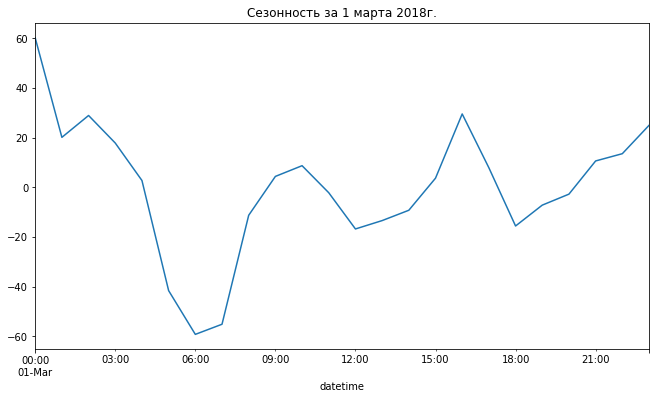

In [11]:
decomposed.seasonal['2018-03-01'].plot(figsize=(11, 6))
plt.title('Сезонность за 1 марта 2018г.');

Графики идентичны

Посмотрим на разницу между основными данными, средним и стандартным отклонениями

In [12]:
df['rolling_mean'] = df.rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()

In [13]:
df.head(20)

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN
2018-03-01 05:00:00,6,NaN,NaN
2018-03-01 06:00:00,12,NaN,NaN
2018-03-01 07:00:00,15,NaN,NaN
2018-03-01 08:00:00,34,NaN,NaN


<AxesSubplot:xlabel='datetime'>

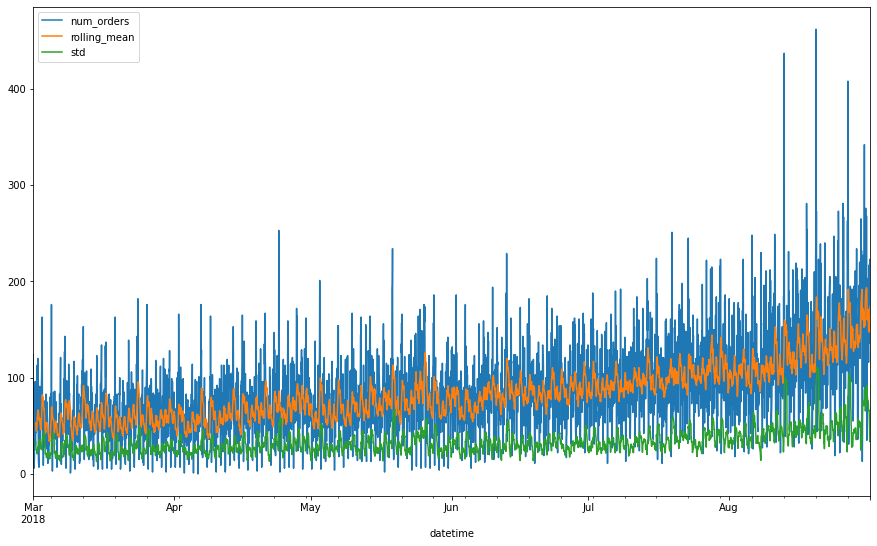

In [14]:
plt.figure(figsize=(15, 9))
df.plot(ax=plt.gca())

На графике видно, что стохастический процесс нестационарный. Число заказов с мая по август постепенно растёт. После проведения обучения и получения валидационных результатов, при слишком высоком RMSE можно будет привести его к стационарному.

## Обучение

Добавим признаки. При помощи функции были внесены данные о месяце, дне, дне недели, и часе. Также перебором параметров были подобраны скользящее среднее и отстающие значения

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


In [16]:
df = df.drop(['rolling_mean'], axis=1)
df = df.drop(['std'], axis=1)

Подбираем параметры, которые дадут наилучший результат.

In [17]:
make_features(df, 48, 10)
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# разделим данные на выборки
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, shuffle=False, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, shuffle=False, test_size=0.5, random_state=12345)

In [19]:
# Заменим пропуски в трейне
features_train = features_train.fillna(0.0)
features_train.isna().sum()

month           0
day             0
dayofweek       0
hour            0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
lag_25          0
lag_26          0
lag_27          0
lag_28          0
lag_29          0
lag_30          0
lag_31          0
lag_32          0
lag_33          0
lag_34          0
lag_35          0
lag_36          0
lag_37          0
lag_38          0
lag_39          0
lag_40          0
lag_41          0
lag_42          0
lag_43          0
lag_44          0
lag_45          0
lag_46          0
lag_47          0
lag_48          0
rolling_mean    0
dtype: int64

### Проверим работу модели CatBoost

In [20]:
%%time
start_time_cat = timeit.default_timer()
# CatBoost

param_grid_cat = {
    'max_depth': np.arange(4, 10, 2),
    'learning_rate': np.arange(0.1, 0.4, 0.1)
}

tscv = TimeSeriesSplit(n_splits=5)

model_cat = CatBoostRegressor(loss_function='RMSE', iterations=20, random_state=12345)
grid_search_cat = GridSearchCV(model_cat, param_grid=param_grid_cat, cv=tscv, scoring='neg_mean_squared_error')
grid_search_cat.fit(features_train, target_train)

end_time_cat = timeit.default_timer()
total_time_cat = end_time_cat - start_time_cat

0:	learn: 28.2032552	total: 190ms	remaining: 3.61s
1:	learn: 27.0842343	total: 198ms	remaining: 1.78s
2:	learn: 26.0342443	total: 211ms	remaining: 1.2s
3:	learn: 25.0819706	total: 226ms	remaining: 905ms
4:	learn: 24.3074244	total: 238ms	remaining: 715ms
5:	learn: 23.7563756	total: 241ms	remaining: 562ms
6:	learn: 23.2193447	total: 244ms	remaining: 452ms
7:	learn: 22.6746916	total: 247ms	remaining: 371ms
8:	learn: 22.0910508	total: 252ms	remaining: 307ms
9:	learn: 21.6104349	total: 255ms	remaining: 255ms
10:	learn: 21.3531332	total: 259ms	remaining: 212ms
11:	learn: 21.0228448	total: 264ms	remaining: 176ms
12:	learn: 20.6534428	total: 267ms	remaining: 144ms
13:	learn: 20.2992303	total: 269ms	remaining: 115ms
14:	learn: 20.0008698	total: 271ms	remaining: 90.4ms
15:	learn: 19.6240976	total: 273ms	remaining: 68.3ms
16:	learn: 19.4029668	total: 275ms	remaining: 48.6ms
17:	learn: 19.1741114	total: 278ms	remaining: 30.9ms
18:	learn: 18.9564410	total: 280ms	remaining: 14.7ms
19:	learn: 18.7111

In [21]:
%%time
rmse_cat = np.sqrt(-grid_search_cat.best_score_)
print("Best parameters: ", grid_search_cat.best_params_)
print("Best RMSE: ", rmse_cat)

Best parameters:  {'learning_rate': 0.2, 'max_depth': 6}
Best RMSE:  23.78795743337307
Wall time: 0 ns


In [22]:
%%time
start_time_cat_pred = timeit.default_timer()

pred_cat = grid_search_cat.predict(features_valid)
rmse_cat_valid = mean_squared_error(target_valid, pred_cat) ** 0.5
print("RMSE CatBoost на valid: ", rmse_cat_valid)

end_time_cat_pred = timeit.default_timer()
total_time_cat_pred = end_time_cat_pred - start_time_cat_pred

RMSE CatBoost на valid:  33.9904192545616
Wall time: 15.6 ms


### Проверим работу модели RandomForest

In [23]:
%%time
start_time_RF = timeit.default_timer()
# Случайное древо

model_RF = RandomForestRegressor(random_state=12345)
param_grid = {
    'max_depth': np.arange(2,10,2),
    'n_estimators': [100, 200]
}
grid_search = GridSearchCV(model_RF, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(features_train, target_train)

end_time_RF = timeit.default_timer()
total_time_RF = end_time_RF - start_time_RF

Wall time: 1min 50s


In [24]:
%%time

rmse_RF = np.sqrt(-grid_search.best_score_)
print("Best parameters: ", grid_search.best_params_)
print("Best RMSE случайного древа: ", rmse_RF)

Best parameters:  {'max_depth': 8, 'n_estimators': 200}
Best RMSE случайного древа:  23.40799210086312
Wall time: 0 ns


In [25]:
%%time
start_time_RF_pred = timeit.default_timer()

pred_RF = grid_search.predict(features_valid)
rmse_RF_valid = mean_squared_error(target_valid, pred_RF) ** 0.5
print("RMSE случайного древа на valid: ", rmse_RF_valid)

end_time_RF_pred = timeit.default_timer()
total_time_RF_pred = end_time_RF_pred - start_time_RF_pred

RMSE случайного древа на valid:  32.916504963917006
Wall time: 53.3 ms


### Проверим работу LinearRegression

In [26]:
%%time
start_time_LR = timeit.default_timer()
# Линейная регрессия

model_LR = LinearRegression()
param_grid_LR = {'fit_intercept': [True, False],
                 'copy_X': [True, False]
                }
grid_search_LR = GridSearchCV(model_LR, param_grid=param_grid_LR, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search_LR.fit(features_train, target_train)

end_time_LR = timeit.default_timer()
total_time_LR = end_time_LR - start_time_LR

Wall time: 570 ms


In [27]:
print("Best parameters: ", grid_search_LR.best_params_)

Best parameters:  {'copy_X': True, 'fit_intercept': True}


In [28]:
%%time
start_time_LR_pred = timeit.default_timer()

pred_LR = grid_search_LR.predict(features_valid)
rmse_LR_valid = mean_squared_error(target_valid, pred_LR) ** 0.5
print("RMSE линейной регрессии на valid: ", rmse_LR_valid)

end_time_LR_pred = timeit.default_timer()
total_time_LR_pred = end_time_LR_pred - start_time_LR_pred

RMSE линейной регрессии на valid:  31.840381581553395
Wall time: 15.7 ms


При масштабировании признаков RMSE сильно увеличилось(до 86 на валид), поэтому использовали неизменённые данные.

In [29]:
table = pd.DataFrame(['CatBoost', 'RandomForest', 'LinearRegression'], columns=['Название модели'])

table['RMSE на valid'] = [rmse_cat_valid, rmse_RF_valid, rmse_LR_valid]
table['Длительность обучения'] = [total_time_cat, total_time_RF, total_time_LR_pred]
table['Длительность предсказания'] = [total_time_cat_pred, total_time_RF_pred, total_time_LR_pred]
table

,Название модели,RMSE на valid,Длительность обучения,Длительность предсказания
0,CatBoost,33.990419,28.581979,0.011262
1,RandomForest,32.916505,110.498857,0.050387
2,LinearRegression,31.840382,0.002889,0.002889


Лучшие результаты показала модель линейной регрессии. Она показала:
- самый низкий RMSE на valid
- самую высокую скорость обучения
- высокую скорость предсказаний

Проверим её на тестовой выборке

## Тестирование

Заново подготовим данные для тестирования и обучим новую модель на лучших параметрах

In [31]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False, random_state=12345)

In [32]:
features_train = features_train.fillna(0.0)
features_train.isna().sum()

month           0
day             0
dayofweek       0
hour            0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
lag_25          0
lag_26          0
lag_27          0
lag_28          0
lag_29          0
lag_30          0
lag_31          0
lag_32          0
lag_33          0
lag_34          0
lag_35          0
lag_36          0
lag_37          0
lag_38          0
lag_39          0
lag_40          0
lag_41          0
lag_42          0
lag_43          0
lag_44          0
lag_45          0
lag_46          0
lag_47          0
lag_48          0
rolling_mean    0
dtype: int64

In [33]:
%%time
# Линейная регрессия

best_model_LR = LinearRegression()
best_param_grid_LR = {'fit_intercept': [False],
                 'copy_X': [True]
                }
best_grid_search_LR = GridSearchCV(best_model_LR, param_grid=best_param_grid_LR, cv=5, scoring='neg_root_mean_squared_error')
best_grid_search_LR.fit(features_train, target_train)

best_pred_LR = best_grid_search_LR.predict(features_test)
best_rmse_LR_test = mean_squared_error(target_test, best_pred_LR) ** 0.5
print("RMSE линейной регрессии на test: ", best_rmse_LR_test)

RMSE линейной регрессии на test:  43.446734125095276
Wall time: 132 ms


***Вывод***

RMSE линейной регрессии на test:  43.4, с поставленной задачей модель справилась.

При работе с временными рядами сильнее всего показатель RMSE зависел от предварительной обработки данных, а именно создания новых признаков. Опытным путём были подобраны подходящие параметры.